In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# 4.1 $\quad$ Teoría de Tobin

## 1. Incorporacicón del *activo libre de riesgo*



- El activo libre de riesgo lo denotaremos como **$R_f$** y se caracteriza por :

    - **Retorno Garantizado**: Ofrece un retorno fijo y conocido de antemano: $\quad Retorno \   R_{f,t} = r_f = cte \ \Rightarrow \ E(R_f) = r_f$

    - **Varianza cero**: Como $r_f = cte$ la varrianza es cero: $\quad Var(r_f) =  \sigma^2_f = 0$

    - **Covarianza cero**: La covarianza del activo libre de riesgo con cualquier otro activo es cero: $\quad covar(r_f, r_i) = 0 \qquad \forall i$

    - **Ejemplos Comunes**: Bonos del gobierno de países estables, como los bonos del Tesoro de EE. UU.
 

**¿Qué ocurre cuando creas una cartera con un activo libre de riesgo y uno con riesgo?**

- Activo libre de riesgo: 
  - $E(r_f) = r_f$
  - $Var(r_f) = 0$

- Activo con riesgo:
  - $E(\tilde{r})=\mu$
  - $Var(\tilde{r})=\sigma^2$


Si creamos una cartera mixta $p$ con los pesos $w$ y $1 - w$:

  - El retorno será: $\boxed{E(\tilde{r_p})= w r_f + (1 - w) \mu}$

  - La varianza será: $\sigma^2_p = w^2 \underbrace{Var(r_f)}_{\text{= 0}} + (1-w)^2 Var(\tilde{r}) + 2w(1-w)\underbrace{covar(r_f, \tilde{r})}_{\text{= 0}} = (1-w)^2 \sigma^2 \ \ \Rightarrow \ \boxed{\sigma_p = (1-w)\sigma}$

El riesgo de la cartera sólo depende de la inversión realizada en el activo con riesgo.

Despejando $w$ y sustituyendo en el retorno esperado, tendremos que:

- El retorno de la cartera mixta será: 

$w = 1 - \frac{\sigma_p}{\sigma}$

$E(\tilde{r_p})= \left(1 - \frac{\sigma_p}{\sigma}\right) r_f + \frac{\sigma_p}{\sigma} \mu$

$\boxed{E(\tilde{r_p}) = r_f + \left(\frac{\mu - r_f}{\sigma}\right) \sigma_p}$

- **Inversión en Activo Libre de Riesgo:**
  - Si $w = 1$: Invierte todo en activo libre de riesgo.
- **Inversión en Cartera Eficiente:**
  - Si $w = 0$: Invierte todo en la cartera eficiente.
- **Inversión Combinada:**
  - Si $0 < w < 1$: 
    - Invierte parte en activo libre de riesgo y parte en la cartera eficiente.
    - La rentabilidad y volatilidad de la nueva cartera se calculan con las fórmulas anteriores.
- **Endeudamiento e Inversión en Cartera Eficiente:**
  - Si $w < 0$: 
    - El inversor se endeuda a la tasa libre de riesgo.
    - Invierte todo en la cartera eficiente.



La incorporación del activo libre de riesgo permite:

- **Combinar posiciones en la frontera eficiente** con el activo libre de riesgo.
  
- **Posiciones Largas y Cortas**: Tomar una posición larga en el activo libre de riesgo equivale a prestar dinero sin riesgo, mientras que una posición corta es similar a pedir prestado a la tasa libre de riesgo.
  
- **Ampliación del Conjunto de Oportunidades**: Al introducir préstamo y endeudamiento a la tasa libre de riesgo, se expande el conjunto de oportunidades de inversión.
  
- **Comparación de Carteras en la Frontera Eficiente**: Interesa analizar cómo se compara una cartera en la frontera eficiente con otra que utiliza préstamo o endeudamiento para igualar el retorno esperado de otro punto en la frontera.

## 2. Ejemplos con activos reales

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import cvxpy as cp
import yfinance as yf
import seaborn as sns
#import gurobipy as gp
#from gurobipy import GRB
from scipy.interpolate import interp1d

plt.style.use('ggplot')

#### Descargamos los datos 

In [3]:
# Date range
start = '2015-01-01'
end = '2019-12-30'

# Assets todos con retornos positivos
assets = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ', 
        'JCI', 'JPM','KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

# Downloading data
prices = yf.download(assets, start = start, end = end)['Adj Close']
prices.columns = assets

[*********************100%%**********************]  26 of 26 completed


Elegimos el activo con ticker 'BA' y definimos la rentabilidad del activo libre de riesgo $r_f$

In [4]:
rf = 0.03 # Rentabilidad del activo libre de riesgo (anual)
ret_rf = rf / 252 # Rentabilidad del activo libre de riesgo diaria

retornos = np.log(prices.loc[:, ['BA']]).diff().dropna()

retornos['Rf'] = ret_rf

Vamos a generar carteras con esos dos activos generando pesos aleatorios:

In [5]:
num_carteras = 1000
num_act = 2

#genero pesos aleatorios
pesos_w1 = np.linspace(-1, 1, 200)
pesos_w2 = 1 - pesos_w1
pesos = np.concatenate((pesos_w2[:, None], pesos_w1[:, None]), axis=1)
pesos.shape

(200, 2)

In [6]:
#calculo retornos y volatilidades
ret_carteras = retornos @ pesos.T

volatilidades = np.sqrt(np.var(ret_carteras, axis=0)*252)
rentabilidades = 252*np.mean(ret_carteras, axis=0)

In [7]:
# Veamos los retornos anualizados de los activos

retornos.mean()*252

BA    0.212925
Rf    0.030000
dtype: float64

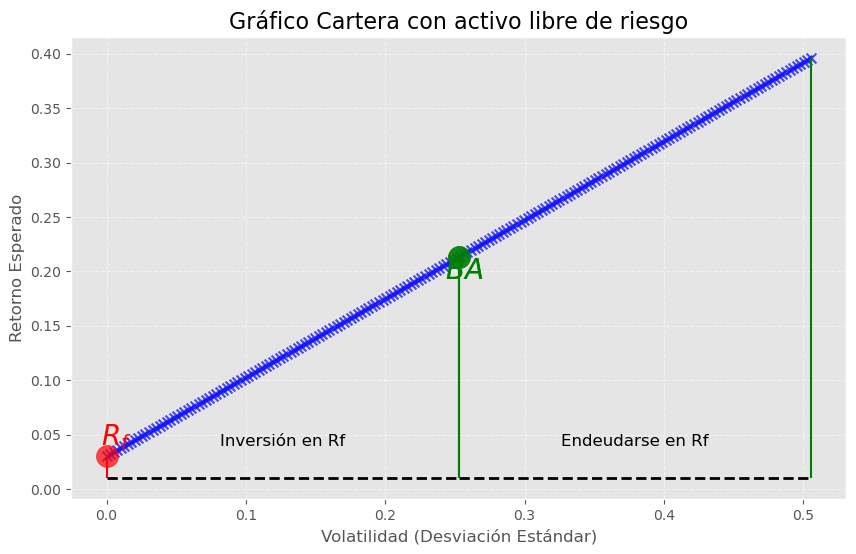

In [8]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))

# Puntos de cada activo
plt.scatter(volatilidades, rentabilidades, color='blue', s=50, marker='x', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.01  # Ajusta este valor según sea necesario


plt.scatter(0, ret_rf*252, color='red', s=250, alpha=0.7)
plt.text(0-4*desplazamiento_x, ret_rf*252+desplazamiento_y, '$R_f$', fontsize=20, color='red')

plt.scatter(retornos['BA'].std()*np.sqrt(252), retornos['BA'].mean()*252, color='green', s=250,  marker='o', alpha=0.7)
plt.text(retornos['BA'].std()*np.sqrt(252)-10*desplazamiento_x, retornos['BA'].mean()*252-2*desplazamiento_y, '$BA$', fontsize=20, color='green')

# Añadiendo títulos y etiquetas
plt.title('Gráfico Cartera con activo libre de riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)



# Coordenadas de los puntos Rf y BA
x_rf = 0
y_rf = ret_rf * 252
x_ba = retornos['BA'].std() * np.sqrt(252)
y_ba = retornos['BA'].mean() * 252

# Dibujar una línea horizontal entre Rf y BA
plt.hlines(y_rf - 0.02, x_rf, x_ba, colors='black', linestyles='dashed', linewidth=2)
plt.vlines(0, y_rf-0.02, y_rf, color="red")
plt.vlines(x_ba, y_rf-0.02, y_ba, color="green")

# Añadir el texto entre Rf y BA
plt.text((x_rf + x_ba) / 2, y_rf + 0.01, 'Inversión en Rf', fontsize=12, ha='center')

# Dibujar una línea horizontal pasado BA
plt.hlines(y_rf - 0.02, x_ba, x_ba*2, colors='black', linestyles='dashed', linewidth=2)
plt.vlines(x_ba, y_rf-0.02, y_ba, color="green")
plt.vlines(x_ba*2, y_rf-0.02, y_ba*2 -0.03, color="green")

# Añadir el texto pasado BA
plt.text((x_ba + x_ba * 2) / 2, y_rf + 0.01, 'Endeudarse en Rf', fontsize=12, ha='center')

# Añadir el punto BA con su etiqueta
plt.scatter(x_ba, y_ba, color='green', s=250, marker='o', alpha=0.7)
plt.text(x_ba - 10 * desplazamiento_x, y_ba - 2 * desplazamiento_y, '$BA$', fontsize=20, color='green')


# Mostrar el gráfico
plt.show()

### EJERCICIO:

Calcula la cartera formada por los dos activos anteriores y que tenga:

 a) una rentabilidad del 14% anual

 b) una rentabilidad del 25% anual

**APARTADO A:**

Sabemos que la rentabilidad de la cartera será $r_p = w r_f + (1-w) r \ \ $ siendo $\ \  r_f = 0.03\  \ y \ \  r = 0.2129$

luego $0.14 = w 0.03 + (1-w) 0.21 \ \ $ y despejando $w$ sale que:

$\boxed{w = 0.389}$

**APARTADO B:**

Hay que resolver la ecuación $0.25 = w 0.03 + (1-w) 0.21 \ \ $ y despejando $w$ sale que:

$\boxed{w = -0.222}$

¿Qué quiere decir este valor de $w$?

## 3. Combinaciones activo libre de riesgo con el resto de los activos

In [9]:
retornos = np.log(prices).diff().dropna()

num_act = len(assets)

In [10]:
#Calculamos la matriz de covarianzas y los retornos esperados
matriz_cov = retornos.cov().to_numpy() # Covariance matrix
retornos_esperados = retornos.mean().to_numpy() # Column vector expected return

Calculemos la frontera eficiente

Primero calculamos la cartera de mínimo riesgo

In [11]:
#Variables de decisión
pesos = cp.Variable(num_act)

#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == 1, # Fully invested
               ]

#Función Objetivo
riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
objective = cp.Minimize(riesgo) # Minimizar la varianza

ret = retornos_esperados.T @ pesos # Retorno esperado de la cartera

#Problema y resuelvo
prob = cp.Problem(objective, constraints)
resultado = prob.solve()

#Guardamos los valores de la rentabilidad y riesgo de la cartera de mínimo riesgo
min_riesgo = np.array([riesgo.value, ret.value])

Definimos los distintos valores de riesgo para calcular la frontera eficiente:

- Riesgo mínimo: El de la cartera de mínimo riesgo

- Riesgo máximo: El del activo de mayor riesgo

In [12]:
np.argmax(retornos.mean(axis=0))

0

In [13]:
imax = np.argmax(retornos.mean(axis=0))
riesgos_lst = np.linspace(min_riesgo[0], np.diag(matriz_cov)[imax], num=500)

Calculamos la cartera de mayor rentabilidad para cada uno de los riesgos anteriores.

In [14]:
retornos_lst = []
pesos_lst = []

for risk in riesgos_lst:
 #Variables de decisión
    pesos = cp.Variable(num_act)

    # Función objetivo
    rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

    #Restricciones
    riesgo = cp.quad_form(pesos, matriz_cov)

    constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    riesgo <= risk
                    ]

    prob = cp.Problem(rentabilidad, constraints)
    resultado = prob.solve(solver=cp.ECOS)
    #resultado = prob.solve(solver=cp.MOSEK)
    retornos_lst.append(rentabilidad.value)
    pesos_lst.append(pesos.value)

/home/disks/ssd1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


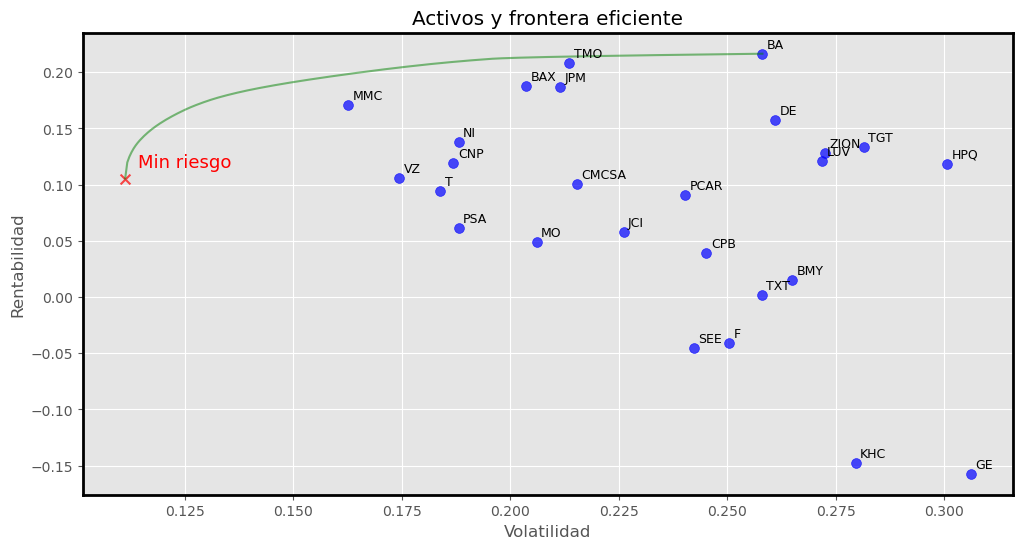

In [15]:
#grafico

plt.figure(figsize=(12, 6))

#Desplazamientos para las etiquetas
desplazamiento_x = 0.001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.005  # Ajusta este valor según sea necesario



plt.scatter(np.sqrt(252*min_riesgo[0]), 252*min_riesgo[1], c='red', marker='x', s=50, alpha=0.7)
plt.text(np.sqrt(252*min_riesgo[0])+ 3*desplazamiento_x, 252*min_riesgo[1] +  2*desplazamiento_y , 'Min riesgo', fontsize=13, color='red')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.7)
plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='green', label='Frontera Eficiente', alpha=0.5)


# Añadiendo los nombres de los activos con un desplazamiento


for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]*252) + desplazamiento_x, 252*retornos_esperados[i]+desplazamiento_y , asset, fontsize=9)
plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Activos y frontera eficiente')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()

Analicemos ahora el efecto de introducir:

- Activo libre de riesgo

- Posibilidad de financiarse o endeudarse con el activo libre de riesgo


Como hemos visto en el capítulo anterior (Markowitz) las únicas carteras que tiene sentido emplear son las de la frontera eficiente. Para comenzar, vamos a elegir la cartera de mínimo riesgo y generamos **carteras mixtas formadas por el activo libre de riesgo y la cartera de mínimo riesgo**. Hemos visto que las carteras formadas formarán una recta que pasa por los dos activos.

In [16]:
# Calculamos la recta que pasa por los puntos de la cartera de mínima varianza y el activo libre de riesgo

punto_rf = np.array([0, ret_rf])
punto_act1 = min_riesgo

# Calculando la pendiente y la intersección con el eje y de la recta
pendiente = (252*punto_act1[1]- 252*punto_rf[1]) / (np.sqrt(252*punto_act1[0]) - punto_rf[0])
interseccion = 252*punto_rf[1] - pendiente * punto_rf[0]

# Extender el rango de x más allá del segundo punto
x_extendido =np.linspace(min(punto_rf[0], np.sqrt(252*punto_act1[0])),max(punto_rf[0], np.sqrt(np.diag(matriz_cov)*252).max()))  # Extender el rango
y_extendido = [pendiente * x + interseccion for x in x_extendido]

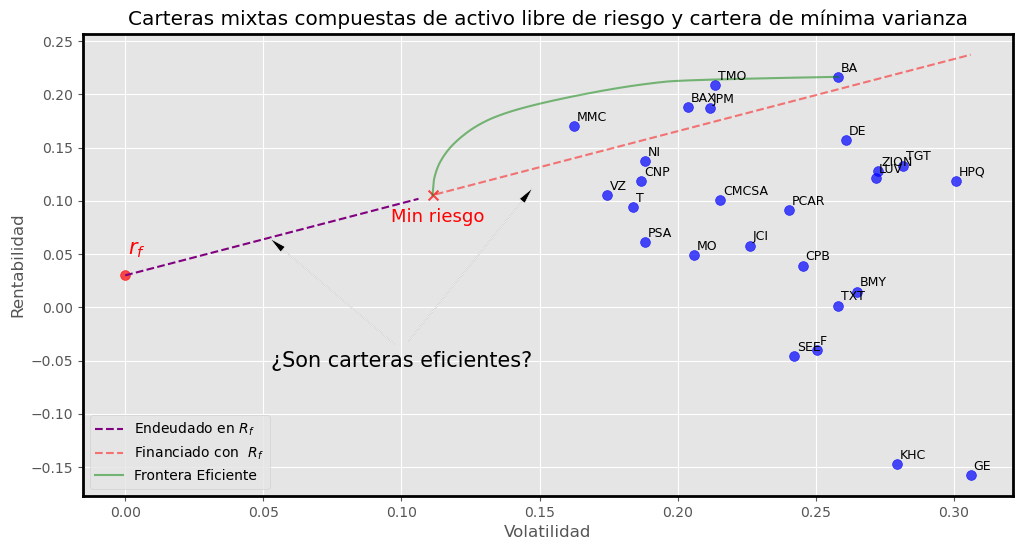

In [17]:
#grafico

plt.figure(figsize=(12, 6))



# Recta de las carteras generadas con activo libre de riesgo y cartera de mínima varianza
#plt.plot(x_extendido, y_extendido, 'r--', alpha=0.5)  # Recta extendida

# Dividir la recta en dos partes: una antes de punto_act1 y otra después
x_punto_act1 = np.sqrt(252 * punto_act1[0])
parte1_x = x_extendido[x_extendido <= x_punto_act1]
parte1_y = [pendiente * x + interseccion for x in parte1_x]
parte2_x = x_extendido[x_extendido > x_punto_act1]
parte2_y = [pendiente * x + interseccion for x in parte2_x]

# Recta de las carteras generadas con activo libre de riesgo y cartera de mínima varianza
plt.plot(parte1_x, parte1_y, c='purple', linestyle='--', alpha=1, label='Endeudado en $R_f$')  # Primera parte de la recta
plt.plot(parte2_x, parte2_y, 'r--', alpha=0.5, label='Financiado con  $R_f$')  # Segunda parte de la recta

# Punto del activo libre de riesgo
plt.scatter(0, 252*ret_rf, c='red', marker='o', s=50, alpha=0.7)
plt.text(desplazamiento_x, 252*ret_rf +  4*desplazamiento_y , '$r_f$', fontsize=15, color='red')

# Punto de la cartera de mínima varianza
plt.scatter(np.sqrt(252*min_riesgo[0]), 252*min_riesgo[1], c='red', marker='x', s=50, alpha=0.7)
plt.text(np.sqrt(252*min_riesgo[0])-15*desplazamiento_x, 252*min_riesgo[1] -  5*desplazamiento_y , 'Min riesgo', fontsize=13, color='red')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.7)

# Frontera eficiente
plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='green', label='Frontera Eficiente', alpha=0.5)

# Añadiendo los nombres de los activos con un desplazamiento
for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]*252) + desplazamiento_x, 252*retornos_esperados[i]+desplazamiento_y , asset, fontsize=9)
plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Carteras mixtas compuestas de activo libre de riesgo y cartera de mínima varianza')
#plt.colorbar(label='Sharpe ratio')

# Añadiendo el texto '¿Son carteras eficientes?' centrado en (0.1, -0.05)
plt.text(0.1, -0.05, '¿Son carteras eficientes?', fontsize=15, ha='center', va='center')

# Añadiendo flechas
plt.annotate('', xy=(0.05, 0.07), xytext=(0.1, -0.04),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5))
plt.annotate('', xy=(0.15, 0.12), xytext=(0.1, -0.04),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5))





# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.legend(loc='lower left')

plt.show()

Puedo elegir otra cartera de la frontera eficiente y generar carteras mixtas con el activo libre de riesgo

In [18]:
punto_act1 = [riesgos_lst[4], retornos_lst[4]]

In [19]:
# Calculando la pendiente y la intersección con el eje y de la recta
pendiente = (252*punto_act1[1]- 252*punto_rf[1]) / (np.sqrt(252*punto_act1[0]) - punto_rf[0])
interseccion = 252*punto_rf[1] - pendiente * punto_rf[0]

# Extender el rango de x más allá del segundo punto
x_extendido =np.linspace(min(punto_rf[0], np.sqrt(252*punto_act1[0])),max(punto_rf[0], np.sqrt(np.diag(matriz_cov)*252).max()))  # Extender el rango
y_extendido = [pendiente * x + interseccion for x in x_extendido]

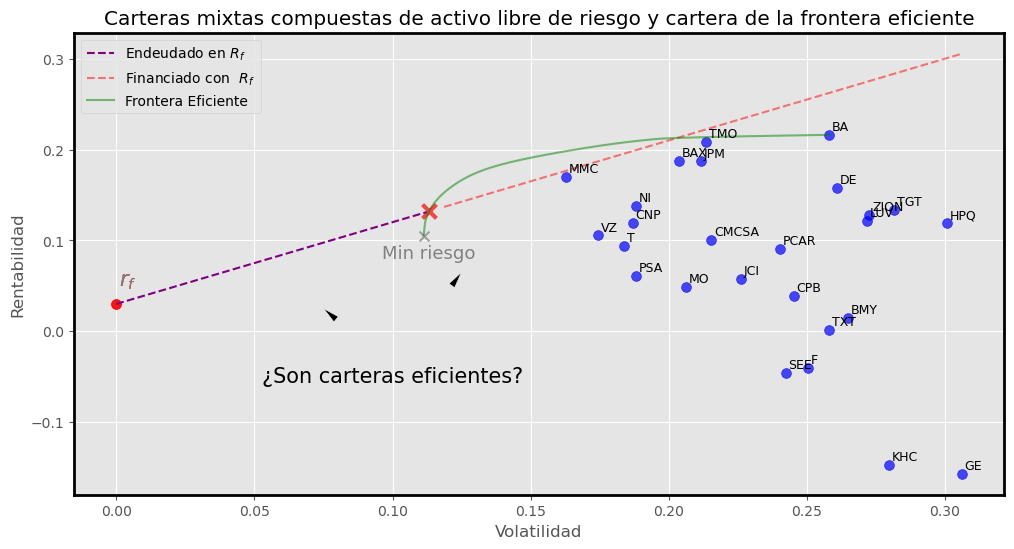

In [20]:
#grafico

plt.figure(figsize=(12, 6))

#Desplazamientos para las etiquetas
desplazamiento_x = 0.001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.005  # Ajusta este valor según sea necesario

# Recta de las carteras generadas con activo libre de riesgo y cartera de mínima varianza
#plt.plot(x_extendido, y_extendido, 'r--', alpha=0.5)  # Recta extendida

# Dividir la recta en dos partes: una antes de punto_act1 y otra después
x_punto_act1 = np.sqrt(252 * punto_act1[0])
parte1_x = x_extendido[x_extendido <= x_punto_act1]
parte1_y = [pendiente * x + interseccion for x in parte1_x]
parte2_x = x_extendido[x_extendido > x_punto_act1]
parte2_y = [pendiente * x + interseccion for x in parte2_x]

# Recta de las carteras generadas con activo libre de riesgo y cartera de mínima varianza
plt.plot(parte1_x, parte1_y, c='purple', linestyle='--', alpha=1, label='Endeudado en $R_f$')  # Primera parte de la recta
plt.plot(parte2_x, parte2_y, 'r--', alpha=0.5, label='Financiado con  $R_f$')  # Segunda parte de la recta

# Punto del activo libre de riesgo
plt.scatter(0, 252*ret_rf, c='red', marker='o', s=50, alpha=0.7)
plt.text(desplazamiento_x, 252*ret_rf +  4*desplazamiento_y , '$r_f$', fontsize=15, color='red')

# Punto de la cartera elegido
plt.scatter(np.sqrt(252*punto_act1[0]), 252*punto_act1[1], c='red', marker='x', s=100, alpha=0.7, linewidths=3)

# Punto del activo libre de riesgo
plt.scatter(0, 252*ret_rf, c='red', marker='o', s=50, alpha=0.7)
plt.text(desplazamiento_x, 252*ret_rf +  4*desplazamiento_y , '$r_f$', fontsize=15, color='grey')

# Punto de la cartera de mínima varianza
plt.scatter(np.sqrt(252*min_riesgo[0]), 252*min_riesgo[1], c='grey', marker='x', s=50, alpha=0.7)
plt.text(np.sqrt(252*min_riesgo[0])-15*desplazamiento_x, 252*min_riesgo[1] -  5*desplazamiento_y , 'Min riesgo', fontsize=13, color='grey')


# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.7)

# Frontera eficiente
plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='green', label='Frontera Eficiente', alpha=0.5)

# Añadiendo los nombres de los activos con un desplazamiento
for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]*252) + desplazamiento_x, 252*retornos_esperados[i]+desplazamiento_y , asset, fontsize=9)
plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Carteras mixtas compuestas de activo libre de riesgo y cartera de la frontera eficiente')
#plt.colorbar(label='Sharpe ratio')

# Añadiendo el texto '¿Son carteras eficientes?' centrado en (0.1, -0.05)
plt.text(0.1, -0.05, '¿Son carteras eficientes?', fontsize=15, ha='center', va='center')

# Añadiendo flechas
plt.annotate('', xy=(0.05, 0.09), xytext=(0.1, -0.04),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5))
plt.annotate('', xy=(0.15, 0.17), xytext=(0.1, -0.04),
             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5))


# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.legend(loc='best')

plt.show()

Veamos las rectas para varias carteras de la frontera eficiente

In [21]:
posiciones = [0, 4, 37]  # Posiciones de las carteras en la frontera eficiente

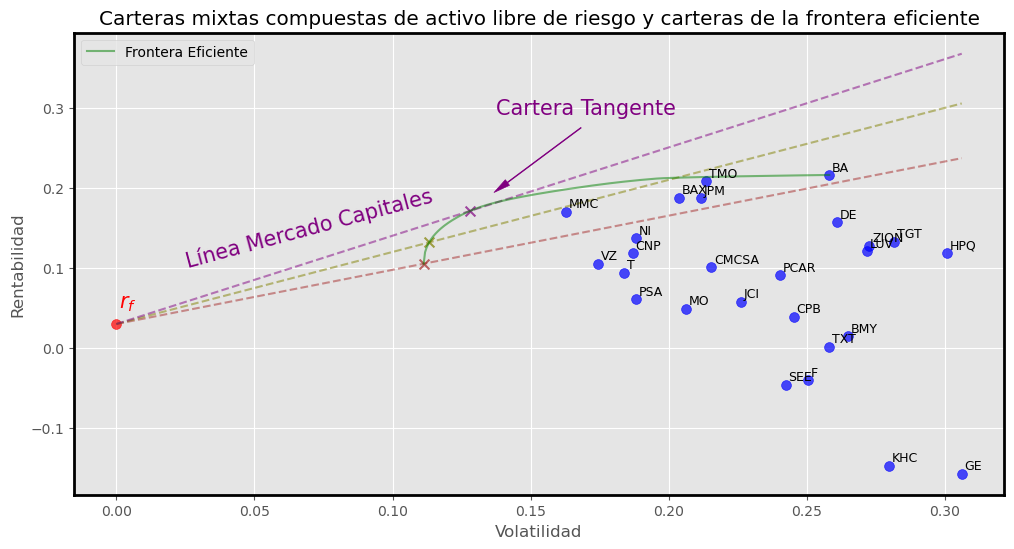

In [22]:
#grafico

# Definiendo una lista de colores
colores = ['brown', 'olive', 'purple', 'red',  'brown', 'pink', 'gray', 'olive']

plt.figure(figsize=(12, 6))

for col, pos in enumerate(posiciones):
    punto_act1 = [riesgos_lst[pos], retornos_lst[pos]] # Selección de la cartera de la frontera eficiente

    color=colores[col]

    plt.scatter(np.sqrt(252*punto_act1[0]), 252*punto_act1[1], c=color, marker='x', s=50, alpha=0.7) # Punto de la cartera de la frontera eficiente

    # Calculando la pendiente y la intersección con el eje y de la recta
    pendiente = (252*punto_act1[1]- 252*punto_rf[1]) / (np.sqrt(252*punto_act1[0]) - punto_rf[0]) # Pendiente

    interseccion = 252*punto_rf[1] - pendiente * punto_rf[0] 

    y_extendido = [pendiente * x + interseccion for x in x_extendido] # Recta extendida

    
    plt.plot(x_extendido, y_extendido, '--', alpha=0.5, color=color)  # Pinto Recta extendida

# Punto del activo libre de riesgo
plt.scatter(0, 252*ret_rf, c='red', marker='o', s=50, alpha=0.7)
plt.text(desplazamiento_x, 252*ret_rf +  4*desplazamiento_y , '$r_f$', fontsize=15, color='red')

# Punto de la cartera de mínima varianza
#plt.text(np.sqrt(252*min_riesgo[0])-15*desplazamiento_x, 252*min_riesgo[1]-6*desplazamiento_y , 'Min riesgo', fontsize=11, color='brown')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]*252) + desplazamiento_x, 252*retornos_esperados[i]+desplazamiento_y , asset, fontsize=9)
plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Carteras mixtas compuestas de activo libre de riesgo y carteras de la frontera eficiente')
#plt.colorbar(label='Sharpe ratio')

# Frontera eficiente
plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='green', label='Frontera Eficiente', alpha=0.5)



# Añadiendo el texto '¿Son carteras eficientes?' centrado en (0.1, -0.05)
plt.text(0.17, 0.3, 'Cartera Tangente', fontsize=15, ha='center', va='center', color='purple')

plt.annotate('', xy=(0.135, 0.19), xytext=(0.17, 0.28),
             arrowprops=dict(shrink=0.05, width=0.5, headwidth=5, color = 'purple'))


# Añadiendo el texto '¿Son carteras eficientes?' centrado en (0.1, -0.05)
plt.text(0.07, 0.15, 'Línea Mercado Capitales', fontsize=15, ha='center', va='center', rotation=15, color = 'purple')


# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.legend(loc='best')

plt.show()

## 4. Linea del mercado de capitales 

Vamos a determinar formalmente la **Línea del Mercado de Capilates (LMC)**:

Para ello, analizamos la estructura de la frontera eficiente cuando introducimos el activo libre de riesgo:

$$\begin{gather}
max \text{   } w_0r_f+\mu^T w-\lambda w^T\Sigma w \tag{1}\\
s.t. \text{   } w_0+w=1 \nonumber
\end{gather}$$

siendo:

- $w_0$ la inversión en el activo libre de riesgo,

- $w$ la inversión en el activo con riesgo,

- $r_f$ es la rentabilidad del activo libre de riesgo,

- $\mu$ es la rentabilidad esperada del activo con riesgo,

- $\lambda$ es el coeficiente de aversión al riesgo del inversor

- $\Sigma$ la matriz de covarianzas.


La ecuación anterior se puede reescribir como un problema sin restricciones eliminando $w_0$, para ello:

- despejamos $w_0$ de la restricción
- sutituimos en la función objetivo
- simplificamos y rescribimos
  
$$\max \text{   } w^T\pi - \lambda w^T\Sigma \tag{2}w$$

donde $\pi=\mu-R_f$ es el vector de la prima por riesgo. 

Aplicamos la condición de primer orden (derivamos e igualamos a 0):

$$\pi-2\lambda\Sigma w=0 \tag{3}$$

Resolviendo obtenemos las ponderaciones una cartera mixta eficiente:

$$w^*=\frac{1}{\lambda}\Sigma^{-1}\pi$$
$$w_0^*=1-w^{*T} \quad \Rightarrow w_0^*=1-\frac{1}{\lambda}i^T\Sigma^{-1}\pi$$

Observamos que cuando $\lambda \rightarrow +\infty$ la totalidad de la inversión se destina al activo libre de riesgo.

El coeficiente $\lambda$ determina el peso del activo libre de riesgo en la cartera.

## 5. Teoría separación Tobin

Hasta ahora hemos realizado:

- **Cálculo de Carteras Eficientes para un Inversor:** Se ha considerado la función de utilidad del inversor, enfocándose en la tolerancia al riesgo y la rentabilidad esperada.

- **Introducción del Activo Libre de Riesgo:** Al introducir un activo libre de riesgo, se observa que la cartera que importa de la frontera eficiente es la cartera tangente.

- **Cartera Tangente en la Frontera Eficiente:** La cartera tangente es la misma para cualquier inversor, independientemente de su función de utilidad.

- **Selección de Cartera en la Línea de Mercado de Capitales:** Cualquier inversor seleccionará una cartera de la Línea de Mercado de Capitales (LMC).

La **teoría de separación de Tobin** dice que la selección de cartera se divide en **dos fases**:

1- Identificación de la **cartera tangente**.

2- Cada inversor particular elige su posición en la LMC según su aversión al riesgo.

Esta afirmación lleva implícito las siguientes hipótesis:

- Los inversores optimizan el binomio rentabilidad riesgo.
- Comparten la misma estimación de premio por riesgo, volatilidad y correlaciones. Eso implica que tienen acceso a la misma información sin coste.

### Cálculo de la cartera tangente

En la figura anterior vemos que las carteras eficientes son las **carteras mixtas** que están en la recta tangente que pasa por $r_f$.

La recta tangente es, de las rectas posibles, la que tiene máxima pendiente.

En la figura de abajo, podemos ver que la pendiente es el $\text{Ratio de Sharpe} = \Large \frac{r_p - r_f}{\sigma_p}$

Luego tenemos que calcular la **cartera con máximo ratio de sharpe**.

<img src="../imgs/sharpe.PNG"  alt="drawing" width="400"/>

### Maximizar el ratio de sharpe

Lo vamos a resolver de dos maneras:

-  Primero lo resolvemos de manera analítica

- Luego lo resolvemos usando la libería cvxpy en python

#### 1)  Cálculo del máximo ratio de sharpe de manera analítica:

Se trata de resolver:

$$\begin{gather}
max\text{  }\frac{\sum_i(\mu_i-r_f)w_i}{\sqrt{w^T\Sigma w}}=\frac{\pi^Tw}{\sqrt{w^T\Sigma w}}=S_p(w) \tag{11} \\ 
s.t. \sum_i w_i=1 \nonumber
\end{gather}$$

Podemos abordar el problema introduciendo multiplicadores de Lagrange, pero también podemos aprovechar un truco.

El ratio de Sharpe es una función homogénea de grado cero
$$S_p(\alpha w)=S_p(w), \forall \alpha >0$$

Eso implica que puedo resolver el problema de optimización sin necesidad de imponer la restricción.

Por tanto podemos maximizar la función $S_p(x)$, siendo el vector $x$ las pseudoponderaciones que posteiormente normalizaremos.

$$w_i=\frac{x_i}{\sum_k x_k}  \tag{12}$$

La identfiación de la cartera óptima la obtendremos aplicando la condición de primer orden a la siguiente función:

$$S_p(x)=\frac{\pi^Tx}{(x^T\Sigma x)^{1/2}}  \tag{13}$$

Lo que nos lleva a resolver el siguiente sistema de ecuaciones:
$$\frac{\partial S_p}{\partial x_1}=0, \text{  } \frac{\partial S_p}{\partial x_2}=0, \text{  }..., \frac{\partial S_p}{\partial x_n}=0. \tag{14}$$

El ratio de Sharpe tiene la siguiente estructura:
$$\theta=\frac{f(x)}{\sqrt{g(x)}} \tag{15}$$

Por tanto la condición de primer orden será:

$$\frac{\partial f}{\partial x_k}g^{-\frac{1}{2}}-\frac{1}{2}f(x)g^{-\frac{3}{2}}(x)\frac{\partial g}{\partial x_k}=0, k=1,...,n \tag{16}$$

Si asumimos que $g(x)\neq 0$, podemos simplificar la ecuación 16:

$$\frac{\partial f}{\partial x_k}=\frac{1}{2}\frac{ f(x)}{g(x)}\frac{\partial g}{\partial x_k}, k=1,...,n \tag{17}$$

Lo que se puede expresar como:

$$\bigtriangledown f(x)=\frac{1}{2}\frac{ f(x)}{g(x)}\bigtriangledown g(x) \tag{18}$$

Las características de las funiciones $f(·)$ y $g(·)$ nos permiten resolver la ecuación 18:
- $g(·)$ es cuadrática y el gradiente de la matriz $x^T\Sigma x$ es $2\Sigma x$.
- El gradiente de la función lineal $f(x)=\pi^Tx$ es el vector $\pi$.
- El cociente $\frac{ f(x)}{g(x)}$ es sólo un número por ello no lo tendremos en cuenta. Consideramos que está incluido en el vector $x$ que posteriormente normalizaremos.

La condición de primer orden genera el siguiente sistema de ecuaciones:

$$\Sigma x=\pi \rightarrow \boxed{x=\Sigma^{-1} \pi} \tag{19}$$

Por último, recordad que hay que deshacer la transformación para recuperar el vector $w$:

$$w_i = \frac{x_i}{\sum_{k=1} x_k}$$

### 2) Cálculo del máximo ratio de sharpe con python

### Cartera de **máximo ratio de sharpe**

El **ratio de sharpe**  es una medida para calcular el rendimiento ajustado al riesgo de una inversión, se define como:

- la diferencia entre el retorno de una inversión y la tasa libre de riesgo (**prima por riesgo**)
- dividido por la desviación estándar de la inversión (es decir, el riesgo). 


Matemáticamente, se expresa como:

$\qquad \qquad \text{Ratio de Sharpe} = \Large \frac{r_p - r_f}{\sigma_p}$

Donde:
- $ r_p $ es el retorno esperado de la cartera.
- $ r_f $ es la tasa de retorno libre de riesgo.
- $ \sigma_p = \sqrt{\sigma^2_p}$ es la desviación estándar de los retornos de la cartera, que representa el riesgo.

### Por qué el Ratio de Sharpe no es una función convexa

La naturaleza no convexa del *ratio de Sharpe* se debe a las características de su formulación matemática:

- **Forma de la Función**: El ratio de Sharpe  es una fracción con el riesgo (una raíz cuadrada) en el denominador.

- **Desviación Estándar (Riesgo)**: La desviación estándar, $\sigma_p$, es una función cóncava porque es la raíz cuadrada de la varianza (que es una suma de cuadrados).
En matemáticas, la raíz cuadrada de una función cuadrática no es convexa.

- **División por una Función Cóncava**: Dividir una función lineal (el exceso de retorno) por una función cóncava (la desviación estándar) resulta en una función que no es necesariamente convexa. Las operaciones que involucran la división por funciones cóncavas no preservan la convexidad.

- **Violación de la Desigualdad de Jensen**: Una propiedad clave de las funciones convexas es que deben cumplir la desigualdad de Jensen. El ratio de Sharpe no cumple con esta desigualdad debido a su denominador cóncavo.

En resumen, la combinación de una función lineal en el numerador y una función cóncava en el denominador es lo que hace que el ratio de Sharpe no sea convexo. Esto tiene implicaciones importantes en optimización, ya que los métodos estándar para optimizar funciones convexas no pueden aplicarse directamente para maximizar el ratio de Sharpe.

### Transformaciones Charnes y Cooper para convertir el problema en convexo [Charnes](https://onlinelibrary.wiley.com/doi/10.1002/nav.3800090303)

- **Introducción de Nueva Variable**:
  - Se introduce una nueva variable $ y $, definida como $ y = \frac{1}{\sigma_p} $, donde $ \sigma_p $ es la desviación estándar de los retornos de la cartera.

- **Transformación de Variables de Cartera**:
  - Las variables de ponderación de la cartera $ w_i $ se transforman en nuevas variables $ z_i $.
  - La transformación es $ y_i = w_i * z $.

- **Reformulación de la Función Objetivo**:
  - El objetivo de maximizar $ \frac{R_p - R_f}{\sigma_p} $ se transforma en maximizar $ (R_p - R_f) * y $.
  - La función objetivo se convierte en una función lineal de $ z $ y $ y $.

- **Reformulación de las Restricciones de Cartera**:
  - Las restricciones originales, como la suma de los pesos igual a 1, se reformulan para las nuevas variables.
  - La nueva restricción es $ \sum z_i = y $.

- **Resolución del Problema Transformado**:
  - El problema transformado, ahora lineal, se resuelve utilizando métodos de optimización lineal.

- **Retransformación a Variables Originales**:
  - Después de resolver el problema, se retransforman las variables $ z $ y $ y $ a las variables originales $ x $ para obtener la solución del problema original.

In [23]:

# Variable de decisión (pesos del portafolio)
y = cp.Variable(num_act)
k = cp.Variable(nonneg=True)

# Riesgo (desviación estándar) del portafolio
riesgo = cp.quad_form(y, matriz_cov)

# Rentabilidad del portafolio
ret = retornos_esperados.T @ y

#Restricciones
constraints = [y >= 0,  # No shorting
               cp.sum(y) == k, # Fully invested
               ret - ret_rf * k ==1
               ]

objective = cp.Minimize(riesgo) # Maximizar el ratio de Sharpe

# Problema de optimización
problema = cp.Problem(objective, constraints)         # Sin ventas en corto (pesos no negativos)

# Resolver el problema
problema.solve(solver=cp.ECOS)

# Las ponderaciones óptimas para maximizar el Ratio de Sharpe
pesos_df = pd.DataFrame(y.value/k.value, index=assets)


In [24]:
cartera_sharpe_max = [riesgo.value/k.value, ret.value/k.value]

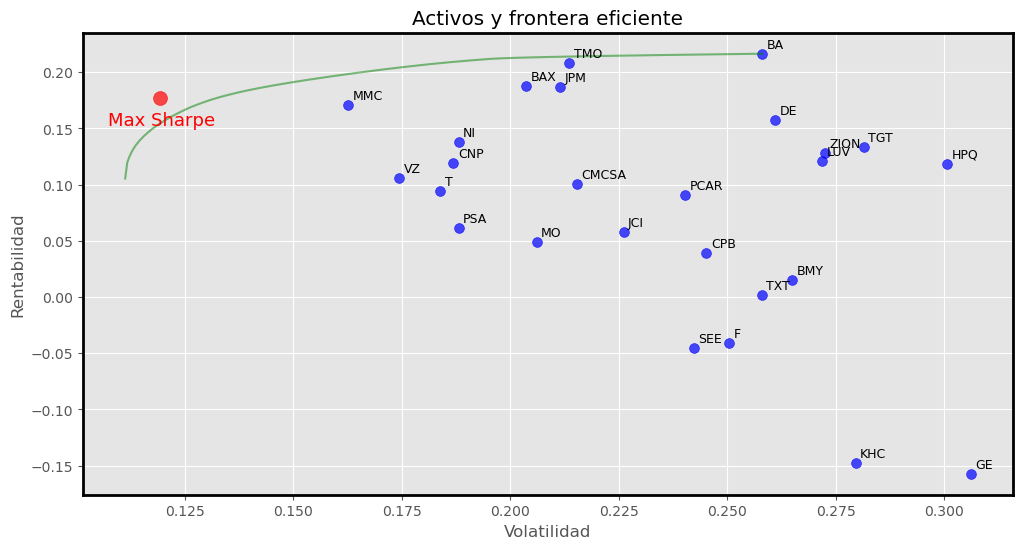

In [25]:
#grafico

plt.figure(figsize=(12, 6))

#Desplazamientos para las etiquetas
desplazamiento_x = 0.001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.005  # Ajusta este valor según sea necesario



plt.scatter(cartera_sharpe_max[0], 252 * cartera_sharpe_max[1], c='red', marker='o', s=100, alpha=0.7)
plt.text(cartera_sharpe_max[0]-12*desplazamiento_x, 252 * cartera_sharpe_max[1]-5*desplazamiento_y , 'Max Sharpe', fontsize=13, color='red')

# plt.scatter(np.sqrt(252*min_riesgo[0]), 252*min_riesgo[1], c='red', marker='x', s=50, alpha=0.7)
# plt.text(np.sqrt(252*min_riesgo[0])+ 3*desplazamiento_x, 252*min_riesgo[1] +  2*desplazamiento_y , 'Min riesgo', fontsize=13, color='red')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.7)
plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='green', label='Frontera Eficiente', alpha=0.5)


# Añadiendo los nombres de los activos con un desplazamiento


for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]*252) + desplazamiento_x, 252*retornos_esperados[i]+desplazamiento_y , asset, fontsize=9)
plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Activos y frontera eficiente')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()

In [26]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos_df.values.reshape(-1,)])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

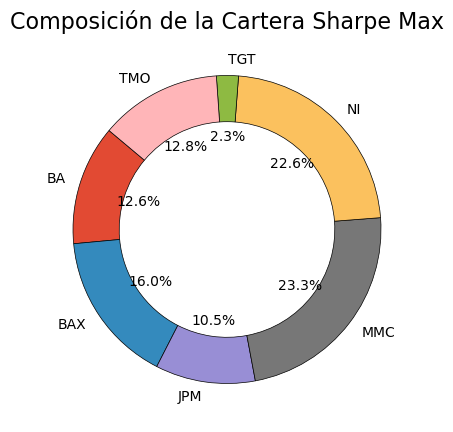

In [27]:
# Crear el gráfico de donut
plt.figure(figsize=(5, 5))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera Sharpe Max', fontsize=16)

# Mostrar el gráfico
plt.show()